#### so the answer for now is to mask the anat down to the approx subvol region, then align subvol to anat

In [1]:
import brainsss
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm
import random
from scipy.stats import sem
import time
import h5py
import ants
import nibabel as nib
import matplotlib
from scipy.ndimage import gaussian_filter1d
from scipy.fftpack import fft,fftshift,ifft
from scipy import signal
import pickle
from matplotlib.colors import Normalize
from shutil import copyfile


/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
fly = 189
load_directory = f'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_{fly}'

In [44]:
subvol_file = os.path.join(load_directory, 'func_0', 'moco', 'functional_channel_1_moc_mean.nii')
subvol = np.asarray(nib.load(subvol_file).get_fdata().squeeze(), dtype='float32')
subvol.shape

(127, 32, 14)

In [47]:
subvol = ants.from_numpy(subvol)
subvol.set_spacing((1.5,1.5,3))
subvol = ants.resample_image(subvol,(2,2,2),use_voxels=False)

In [5]:
subvol.shape

(95, 24, 21)

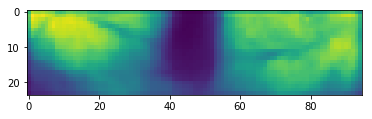

In [6]:
plt.imshow(subvol[:,:,10].T)

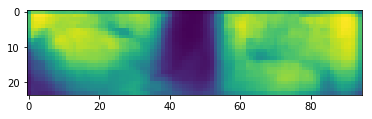

In [7]:
plt.imshow(np.max(subvol.numpy(),axis=-1).T)

In [ ]:
# for now, lets focus on bringing this subvol into FDA space

In [8]:
anat_file = os.path.join(load_directory, 'anat_0', 'moco', 'anatomy_channel_1_moc_mean_clean.nii')
anat = np.asarray(nib.load(anat_file).get_fdata().squeeze(), dtype='float32')

In [9]:
anat.shape

(512, 256, 186)

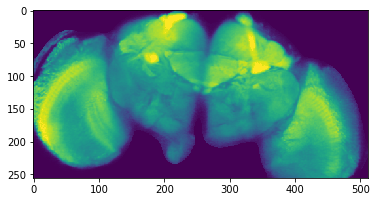

In [10]:
plt.imshow(anat[:,:,105].T)

In [11]:
anat = ants.from_numpy(anat)
anat.set_spacing((1.3,1.3,1.3))
anat = ants.resample_image(anat,(2,2,2),use_voxels=False)

In [12]:
anat.shape

(333, 166, 121)

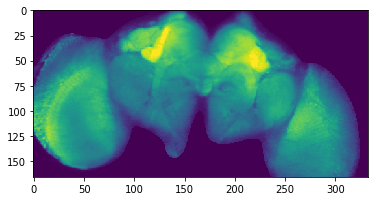

In [13]:
plt.imshow(anat[:,:,80].T)

In [344]:
anat_masked = anat.copy()
anat_masked[:100,:,:] = 0
anat_masked[220:,:,:] = 0
anat_masked[:,:80,:] = 0
anat_masked[:,140:,:] = 0
anat_masked[:,:,:40] = 0
anat_masked[:,:,75:] = 0

In [345]:
subvol, anat_masked

(ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (95, 24, 21)
 	 Spacing    : (2.0, 2.0, 2.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.], ANTsImage (RAI)
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (333, 166, 121)
 	 Spacing    : (2.0, 2.0, 2.0)
 	 Origin     : (0.0, 0.0, 0.0)
 	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.])

In [346]:
subvol2anat = ants.registration(fixed=anat_masked,moving=subvol,type_of_transform='SyN')

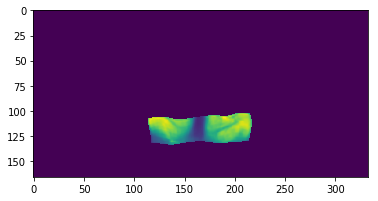

In [347]:
plt.imshow(subvol2anat['warpedmovout'][:,:,60].T)

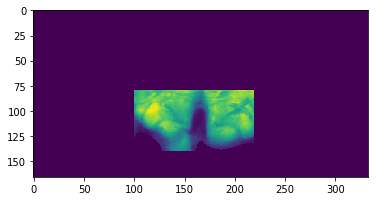

In [348]:
plt.imshow(anat_masked[:,:,60].T)

In [93]:
# make alpha channel so can overlay
temp=subvol2anat['warpedmovout'][:,:,60].T
alpha = np.zeros(temp.shape)
alpha[np.where(temp>0)] = 1
alpha = alpha[:,:,np.newaxis]
temp_norm = Normalize(0, 8066.827)(temp)
rgb = np.repeat(temp_norm[:,:,np.newaxis],3,axis=-1)
overlay = np.concatenate((rgb,alpha),axis=2)

In [89]:
# make alpha channel so can overlay
temp=subvol2anat['warpedmovout']
alpha = np.zeros(temp.shape)
alpha[np.where(temp>0)] = 1
alpha = alpha[...,np.newaxis]
temp_norm = Normalize(0, 8066.827)(temp.numpy())
rgb = np.repeat(temp_norm[...,np.newaxis],3,axis=-1)
overlay = np.concatenate((rgb,alpha),axis=3)
overlay = np.swapaxes(overlay,0,1)

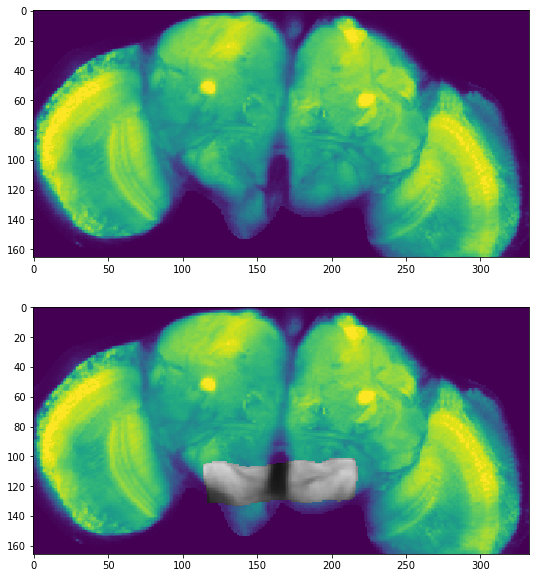

In [350]:
# make alpha channel so can overlay
z=55
temp=subvol2anat['warpedmovout'][:,:,z].T
alpha = np.zeros(temp.shape)
alpha[np.where(temp>0)] = 1
alpha = alpha[:,:,np.newaxis]
temp_norm = Normalize(0, 8066.827)(temp)
rgb = np.repeat(temp_norm[:,:,np.newaxis],3,axis=-1)
overlay = np.concatenate((rgb,alpha),axis=2)

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.imshow(anat[:,:,z].T)
plt.subplot(2,1,2)
plt.imshow(anat[:,:,z].T)
plt.imshow(overlay)

In [352]:
os.mkdir(os.path.join(load_directory, 'warp'))

In [353]:
###########################
### SAVE SUBVOL TO ANAT ###

fwdtransformlist = subvol2anat['fwdtransforms']
fwdtransforms_save_dir = os.path.join(load_directory, 'warp', 'subvol-to-anat_fwdtransforms')
os.mkdir(fwdtransforms_save_dir)

for source_path in fwdtransformlist:
    source_file = source_path.split('/')[-1]
    target_path = os.path.join(fwdtransforms_save_dir, source_file)
    copyfile(source_path, target_path)



In [109]:
subvol2anat['fwdtransforms']

['/tmp/tmp36zfyh141Warp.nii.gz', '/tmp/tmp36zfyh140GenericAffine.mat']

In [108]:
save_file = os.path.join(load_directory,'warp','subvol2anat.nii')
nib.Nifti1Image(subvol2anat['warpedmovout'].numpy(), np.eye(4)).to_filename(save_file)

In [104]:
anat.shape

(333, 166, 121)

# apply subvol2anat, anat2FDA

In [14]:
template = brainsss.load_fda_meanbrain()
template

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (314, 146, 91)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [15]:
save_directory = os.path.join(load_directory, 'warp')

In [16]:
warp_dir = 'subvol-to-anat_fwdtransforms'
syn_files = os.listdir(os.path.join(save_directory, warp_dir))
subvol2anat_linear_path = os.path.join(save_directory, warp_dir, [x for x in syn_files if '.mat' in x][0])
subvol2anat_nonlinear_path = os.path.join(save_directory, warp_dir, [x for x in syn_files if '.nii.gz' in x][0])

In [17]:
warp_dir = 'anat-to-meanbrain_fwdtransforms_2umiso'
syn_files = os.listdir(os.path.join(save_directory, warp_dir))
anat2fda_linear_path = os.path.join(save_directory, warp_dir, [x for x in syn_files if '.mat' in x][0])
anat2fda_nonlinear_path = os.path.join(save_directory, warp_dir, [x for x in syn_files if '.nii.gz' in x][0])

In [18]:
transforms = [
    subvol2anat_nonlinear_path,
    subvol2anat_linear_path
]

In [39]:
subvol

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (95, 24, 21)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [19]:
subvol_in_anat = ants.apply_transforms(anat, subvol, transforms)

In [20]:
transforms = [
    anat2fda_nonlinear_path,
    anat2fda_linear_path
]

In [21]:
moco = ants.apply_transforms(template, subvol_in_anat, transforms)

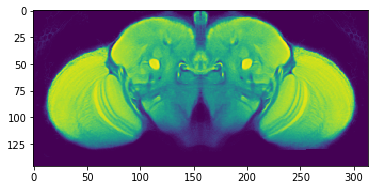

In [38]:
plt.imshow(template[:,:,30].T)

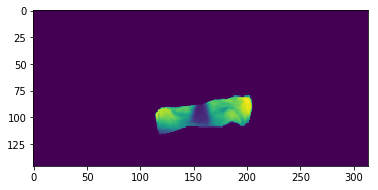

In [37]:
plt.imshow(moco[:,:,30].T)

In [236]:
save_file = os.path.join(load_directory,'warp','subvol2fda.nii')
nib.Nifti1Image(moco.numpy(), np.eye(4)).to_filename(save_file)

# load FDA correlations

In [24]:
### Load Luke Mean ###
luke_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/20210310_luke_exp_thresh.nii"
res_luke_mean = (0.65,0.65,1)
luke_mean = np.asarray(nib.load(luke_path).get_data().squeeze(), dtype='float32')
luke_mean = luke_mean[:,:,::-1] #flipz
luke_mean = ants.from_numpy(luke_mean)
luke_mean.set_spacing(res_luke_mean)
luke_mean_lowres =  ants.resample_image(luke_mean,(256,128,49),use_voxels=True)

In [25]:
### Load JFRC2018 ###
fixed_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/JRC2018_FEMALE_38um_iso_16bit.nii"
res_JRC2018 = (0.38, 0.38, 0.38)
fixed = np.asarray(nib.load(fixed_path).get_data().squeeze(), dtype='float32')
fixed = ants.from_numpy(fixed)
fixed.set_spacing(res_JRC2018)
fixed_lowres = ants.resample_image(fixed,(2,2,2),use_voxels=False)

In [26]:
################################
### Load voxel-res corr data ###
################################

dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210420_correlation/"
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
maps = {}
for behavior in behaviors:
    rvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'rvalues_{}'.format(behavior) in x]
    brainsss.sort_nicely(rvalues_to_load)

    pvalues_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if 'pvalues_{}'.format(behavior) in x]
    brainsss.sort_nicely(pvalues_to_load)
    
    r_map = []
    p_map = []
    for z in range(49):
        r_map.append(np.load(rvalues_to_load[z]))
        p_map.append(np.load(pvalues_to_load[z]))

    r_map = np.asarray(r_map)
    p_map = np.asarray(p_map)
    
    r_map = np.reshape(r_map, (49,256,128))
    p_map = np.reshape(p_map, (49,256,128))
    
    r_map[p_map >= 1e-4]=0
    
    maps[behavior] = r_map
    
############################################
### Put into plotting format with colors ###
############################################

slices = []
for z in range(49):
    colors1 = maps['Z_neg'][z,:,:].T
    colors2 = maps['Z_pos'][z,:,:].T
    colors3 = maps['Y_pos'][z,:,:].T
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)
slices = np.asarray(slices)

func = np.swapaxes(slices, 0, 2)
func.shape

moving = ants.from_numpy(func[:,:,::-1,:])
moving.set_spacing((2.6076, 2.6154, 5.3125, 1)) ### matching this to the slightly off luke mean
out = ants.registration(fixed_lowres, luke_mean_lowres, type_of_transform='Affine')
maps_voxel_res = ants.apply_transforms(fixed_lowres, moving, out['fwdtransforms'][0], imagetype=3, interpolator='nearestNeighbor')
maps_voxel_res.shape

(314, 146, 91, 3)

In [27]:
maps_voxel_res = maps_voxel_res[:,:,::-1,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


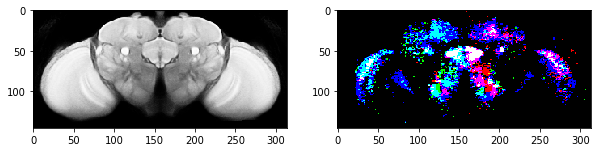

In [28]:
plt.figure(figsize=(10,10))
z=38
plt.subplot(1,2,1)
plt.imshow(np.swapaxes(template[:,:,z],0,1),cmap='Greys_r')
plt.subplot(1,2,2)
plt.imshow(np.swapaxes(maps_voxel_res[:,:,z,:]*100,0,1))

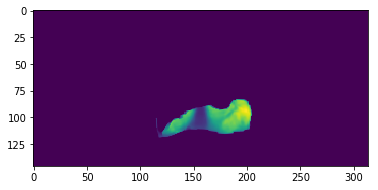

In [35]:
plt.imshow(moco[:,:,z].T)

# load subvol corr and apply warps

In [48]:
corr_dir = os.path.join(load_directory,'func_0','corr')
files = os.listdir(corr_dir)
files

['20220420_corr_dRotLabZpos.nii',
 '20220420_corr_dRotLabY.png',
 '20220420_corr_dRotLabY.nii',
 '20220420_corr_dRotLabZneg.png',
 '20220420_corr_dRotLabZneg.nii',
 '20220420_corr_dRotLabZpos.png']

In [30]:
corr_dir

'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_189/func_1/corr'

In [45]:
corr_file = os.path.join(corr_dir, files[0])
corrs = np.asarray(nib.load(corr_file).get_fdata().squeeze(), dtype='float32')
# corrs = ants.from_numpy(corrs)
# corrs.set_spacing((1.5,1.5,3))
# corrs = ants.resample_image(corrs,(2,2,2),use_voxels=False)

In [46]:
corrs.shape

(256, 128, 49)

In [49]:
def load_and_warp(file):
    corr_file = os.path.join(corr_dir, file)
    corrs = np.asarray(nib.load(corr_file).get_fdata().squeeze(), dtype='float32')
    corrs = ants.from_numpy(corrs)
    corrs.set_spacing((1.5,1.5,3))
    corrs = ants.resample_image(corrs,(2,2,2),use_voxels=False)

    save_directory = os.path.join(load_directory, 'warp')

    warp_dir = 'subvol-to-anat_fwdtransforms'
    syn_files = os.listdir(os.path.join(save_directory, warp_dir))
    subvol2anat_linear_path = os.path.join(save_directory, warp_dir, [x for x in syn_files if '.mat' in x][0])
    subvol2anat_nonlinear_path = os.path.join(save_directory, warp_dir, [x for x in syn_files if '.nii.gz' in x][0])

    warp_dir = 'anat-to-meanbrain_fwdtransforms_2umiso'
    syn_files = os.listdir(os.path.join(save_directory, warp_dir))
    anat2fda_linear_path = os.path.join(save_directory, warp_dir, [x for x in syn_files if '.mat' in x][0])
    anat2fda_nonlinear_path = os.path.join(save_directory, warp_dir, [x for x in syn_files if '.nii.gz' in x][0])

    transforms = [
        subvol2anat_nonlinear_path,
        subvol2anat_linear_path
    ]

    subvol_in_anat = ants.apply_transforms(anat, corrs, transforms)

    transforms = [
        anat2fda_nonlinear_path,
        anat2fda_linear_path
    ]

    moco = ants.apply_transforms(template, subvol_in_anat, transforms)
    
    return moco

In [50]:
files = ['20220420_corr_dRotLabZneg.nii',
         '20220420_corr_dRotLabZpos.nii',
         '20220420_corr_dRotLabY.nii']
corrs = []
for file in files:
    print(file)
    corrs.append(load_and_warp(file).numpy())
corrs = np.asarray(corrs)
corrs = np.rollaxis(corrs,0,4)

20220420_corr_dRotLabZneg.nii
20220420_corr_dRotLabZpos.nii
20220420_corr_dRotLabY.nii


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


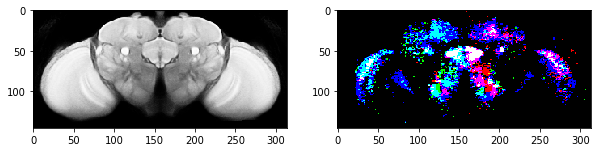

In [33]:
plt.figure(figsize=(10,10))
z=38
plt.subplot(1,2,1)
plt.imshow(np.swapaxes(template[:,:,z],0,1),cmap='Greys_r')
plt.subplot(1,2,2)
plt.imshow(np.swapaxes(maps_voxel_res[:,:,z,:]*100,0,1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


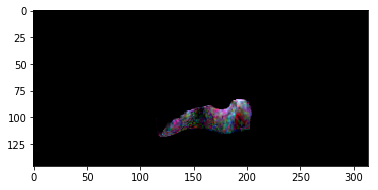

In [51]:
plt.imshow(np.swapaxes(corrs[:,:,z,:]*15,0,1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


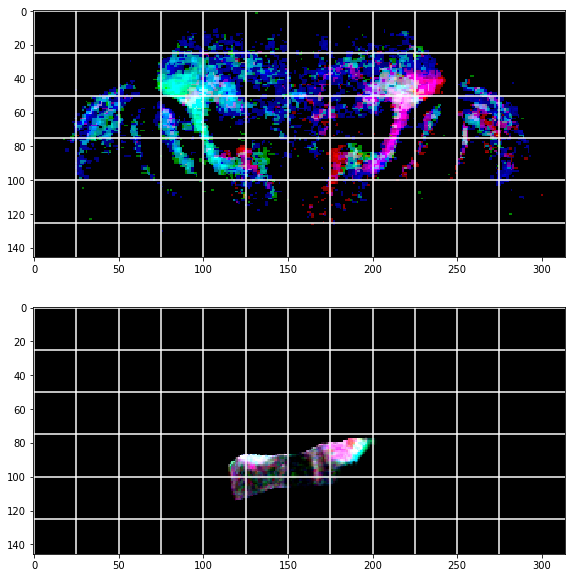

In [54]:
plt.figure(figsize=(10,10))
z=25

vlines = np.arange(0,300,25)
hlines = np.arange(0,140,25)


plt.subplot(2,1,1)
plt.imshow(np.swapaxes(maps_voxel_res[:,:,z,:]*20,0,1))
for line in vlines:
    plt.axvline(line,color='w',linestyle='-')
for line in hlines:
    plt.axhline(line,color='w',linestyle='-')
# plt.xlim(110,200)
# plt.ylim(120,80)

plt.subplot(2,1,2)
plt.imshow(np.swapaxes(corrs[:,:,z,:]*15,0,1))
for line in vlines:
    plt.axvline(line,color='w',linestyle='-')
for line in hlines:
    plt.axhline(line,color='w',linestyle='-')
# plt.xlim(110,200)
# plt.ylim(120,80)

In [257]:
corr_file = os.path.join(corr_dir, '20220420_corr_dRotLabZneg.nii')
R = np.asarray(nib.load(corr_file).get_fdata().squeeze(), dtype='float32')
corr_file = os.path.join(corr_dir, '20220420_corr_dRotLabZpos.nii')
G = np.asarray(nib.load(corr_file).get_fdata().squeeze(), dtype='float32')
corr_file = os.path.join(corr_dir, '20220420_corr_dRotLabY.nii')
B = np.asarray(nib.load(corr_file).get_fdata().squeeze(), dtype='float32')
subvol_rgb = np.stack((R,G,B),axis=2)

In [258]:
subvol_rgb = ants.from_numpy(subvol_rgb)
subvol_rgb.set_spacing((1.5,1.5,1,3))
subvol_rgb = ants.resample_image(subvol_rgb,(2,2,1,2),use_voxels=False)

In [261]:
subvol_rgb

ANTsImage
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (95, 24, 3, 21)
	 Spacing    : (2.0, 2.0, 1.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]

In [262]:
subvol

ANTsImage (RAI)
	 Pixel Type : float (float32)
	 Components : 1
	 Dimensions : (95, 24, 21)
	 Spacing    : (2.0, 2.0, 2.0)
	 Origin     : (0.0, 0.0, 0.0)
	 Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


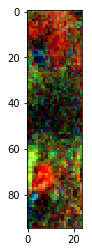

In [260]:
plt.imshow(subvol_rgb[:,:,:,10]*10)

# make video

In [64]:
#file = os.path.join(load_directory, 'func_0', 'functional_channel_2_moco_zscore_highpass.h5')
file = os.path.join(load_directory, 'func_0', 'moco', 'functional_channel_1_moco.h5')

with h5py.File(file, 'r') as hf:
    brain = hf['data'][:][:,:,:,:1000]
    print(brain.shape)

(127, 32, 14, 1000)


In [65]:
brain_cropped = brain[:,:,1:-1,:]
brain_cropped.shape

(127, 32, 12, 1000)

In [66]:
brain_cropped_zscore = (brain_cropped - np.mean(brain_cropped,axis=-1)[...,np.newaxis]) / np.std(brain_cropped,axis=-1)[...,np.newaxis]

In [67]:
smoothed = scipy.ndimage.gaussian_filter(brain_cropped_zscore, sigma=(3,3,3,3), truncate=2) #(2,2,2,4)

In [68]:
smoothed_max = np.max(smoothed, axis=2)

In [69]:
save_file = os.path.join(load_directory, 'func_0', 'videos', '20220804_red_full_3sig')
nib.Nifti1Image(smoothed_max[:,:,:], np.eye(4)).to_filename(save_file)

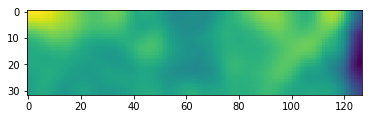

In [62]:
plt.imshow(np.max(smoothed[:,:,:,1000], axis=2).T)

In [32]:
1/.166

6.024096385542168

In [40]:
0.36475248-0.2654844

0.09926807999999998